In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = "realdata"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [26]:
import torch
import numpy as np
import pickle 
import string
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.datasets.mouse_loaders import static_loader
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

In [4]:
def find_number(text, c):
    number_list = re.findall(r'%s(\d+)' % c, text)
    if len(number_list) == 0:
        number = None
    elif len(number_list) == 1:
        number = int(number_list[0])
    else:
        raise ValueError('More than one number found..') 
    return number

def get_transfer(transfer_hashes):
    # prepare the Transfer table in a way that all the info about the transferred model is in the DataFrame. Just pd.merge (on transfer_fn and transfer_hash)
    # it then with the model that the transferred model was used for. 
    
    transfer = pd.DataFrame((Transfer & 'transfer_hash in {}'.format(tuple(transfer_hashes))).fetch())
    transfer = pd.concat([transfer, transfer['transfer_config'].apply(pd.Series)], axis = 1).drop('transfer_config', axis = 1)

    restriction = transfer.rename(columns = {'t_model_hash': 'model_hash', 't_dataset_hash': 'dataset_hash', 't_trainer_hash': 'trainer_hash'})            
    restriction = restriction[['model_hash', 'dataset_hash', 'trainer_hash']].to_dict('records')

    tm = pd.DataFrame((TrainedModel * Dataset * Seed & restriction).fetch()).rename(
        columns = {'model_hash': 't_model_hash', 'trainer_hash': 't_trainer_hash', 'dataset_hash': 't_dataset_hash'})               
    tm = tm.sort_values('score', ascending=False).drop_duplicates(['t_model_hash', 't_trainer_hash', 't_dataset_hash'])

    transfer = pd.merge(transfer, tm, how='inner', on=['t_model_hash', 't_trainer_hash', 't_dataset_hash'])
    transfer = pd.concat([transfer, transfer['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
    transfer.columns = ['t_' + col if col[:2] != 't_' and col[:8] != 'transfer'  else col for col in transfer.columns]
    transfer = transfer.sort_values(['t_multi_match_n', 't_image_n', 't_multi_match_base_seed', 't_image_base_seed'])
    return transfer

# Seed comparison (model, neuron, image)

In [ ]:
experiment_name = 'Real, Direct, se2d_fullgaussian2d, 4-set, seed comparison'

data = pd.DataFrame((TrainedModel * Dataset * Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
#data = data[['seed', 'multi_match_base_seed', 'image_base_seed', 'score']]

seed_model = data.loc[(data['multi_match_base_seed'] == 1) & (data['image_base_seed'] == 5)].copy()
seed_neuron = data.loc[(data['seed'] == 1) & (data['image_base_seed'] == 1)].copy()
seed_image = data.loc[(data['multi_match_base_seed'] == 1) & (data['seed'] == 1)].copy()

seed_model['Seed type'] = 'Model seed'
seed_neuron['Seed type'] = 'Neuron seed'
seed_image['Seed type'] = 'Image seed'

seed_data = pd.concat([seed_model, seed_neuron, seed_image])

In [ ]:
title = 'Seed comparison'
with sns.plotting_context('paper'), sns.color_palette('colorblind'), sns.axes_style('ticks'):
    fig, ax = plt.subplots(dpi=150)
    sns.swarmplot(x="Seed type", y="score",  size=10, data=seed_data, ax=ax)
    sns.despine(trim=True)
    ax.set_xlabel('')
    ax.set_ylabel('validation correlation')
    #fig.savefig('figures/' + title.title().replace(" ", "") + '.png', dpi=150)

# Regularization 

In [ ]:
model_fn = 'nnsysident.models.models.se2d_fullgaussian2d'
#model_fn = 'nnsysident.models.models.se2d_spatialxfeaturelinear'
title = 'Regularization vs Images - ' + model_fn.split('.')[-1][5:]

model = pd.DataFrame((Model & 'model_fn="{}"'.format(model_fn)).fetch())
for arg in ['multi_match_n', 'image_n']:
    model[arg] = [int(find_number(row.model_comment, arg + '=')[0]) for loc, row in model.iterrows()]
model = pd.concat([model, model['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
#model = model.loc[model['multi_match_n'].isin([50, 100, 1000])]
#model = model.loc[model['image_n'] != 50]
model.sort_values(['multi_match_n', 'image_n'], inplace=True)
model.rename(columns={"multi_match_n": "# neurons", "image_n": "# images"}, inplace=True)

with sns.plotting_context('paper'), sns.color_palette('colorblind'), sns.axes_style('ticks'):
    fig, ax = plt.subplots(dpi=150)
    sns.pointplot('# images', "gamma_readout", hue='# neurons', data=model, ax=ax)
    sns.despine(trim=True)
    ax.set_ylabel('readout regularization')
    #plt.legend(loc='lower left')
    #fig.savefig('figures/' + title.title().replace(" ", "") + '.png', dpi=150)

# Directly trained

In [ ]:
experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set', 
                    'Real, Direct, se2d_spatialxfeaturelinear, 4-set',
                    "Real, Direct, se2d_fullgaussian2d, [cortex, ~features], 4-set"]
names = ['gaussian', 'factorized', 'gaussian \nno feature-sharing'] #'gaussian (raw)'
 
# Fetch data
data = pd.DataFrame()
for experiment_name, name in zip(experiment_names, names):
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_['Readout'] = name
    data = pd.concat([data, data_])
    
# Filter out relevant data
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)#.drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1)#.drop('model_config', axis = 1)

# Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['Readout', 
                                                                   'multi_match_n',
                                                                   'image_n', 
                                                                   'multi_match_base_seed',
                                                                   'image_base_seed']).sort_values(['Readout', 'multi_match_n', 'image_n'])
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'].isin([50, 500, 3625])]
#data.replace({'Readout': {'spatialxfeaturelinear':'factorized ', 'fullgaussian2d':'gaussian', 'pointpooled':'Point-Pooled'}}, inplace=True)

In [ ]:
scoring_measure = "fraction_oracle"
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,8, 9) ]

title = 'Direct training - readout comparison'
    
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):     
    
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Readout", 
                    style="# neurons",
                    kind="line",
                    data=data,
                    markers=True,
                    height=7,
                    aspect=0.9,
                    palette=palette) 
    
    ax = g.axes[0, 0]
    
    ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=28)
    ax.set_ylabel(scoring_measure.replace('_', ' ').capitalize(), fontsize=28)
    ax.tick_params(labelsize=25)
    ax.set_yticks([.1, .3, .5, .7, .9])
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    sns.despine(trim=True)
    plt.tight_layout()
    
    idx = [5, 6, 7, 1, 2, 3]
    h, l = ax.get_legend_handles_labels()
    h = [h[i] for i in idx]
    l = [l[i].capitalize() for i in idx]
    g._legend.remove()
    g.fig.legend(h,l, ncol=2, frameon=False, bbox_to_anchor=(0.45, 0.25, 0.5, 0.2), fontsize=22)
    
    # add title to the legend
    ax.text(4000, .4, "# neurons", fontsize=25, )
    ax.text(11500, .4, "Readout", fontsize=25)
    
    #g.fig.savefig('figures/' + title.title().replace(" ", "").replace(",", "-") + '.pdf', dpi=150, bbox_inches='tight')

# Transfer: Condition comparison

In [23]:
# direct data
experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set, last 972 neurons', 'Real, Direct, se2d_spatialxfeaturelinear, 4-set, last 972 neurons']
# Fetch data
data = pd.DataFrame()
for experiment_name in experiment_names:
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data = pd.concat([data, data_])
    
# Filter out relevant data
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]

# Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['Readout', 
                                                                   'multi_match_n',
                                                                   'image_n', 
                                                                   'multi_match_base_seed',
                                                                   'image_base_seed']).sort_values(['Readout', 'multi_match_n', 'image_n'])
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'] == 972]
data.replace({'Readout': {'spatialxfeaturelinear':'Factorized readout ', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point-Pooled'}}, inplace=True)
direct_data = data.copy()
direct_data['Condition'] = "direct"


# full readout data
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (sameNI), se2d_fullgaussian2d, 4-set -> 4-set, last 972 neurons", 
                        "Real, core_transfer (sameNI), se2d_spatialxfeaturelinear, 4-set -> 4-set, last 972 neurons"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data['t_image_n'] = data['t_image_n'] * 4
data = data.rename(columns = {'t_multi_match_n': '# neurons', 't_image_n': "# images"})
data = data.loc[data['# neurons'] == 1000]
data.replace({'Readout': {'spatialxfeaturelinear':'Factorized readout ', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point-Pooled'}}, inplace=True)
full_readout_data = data.copy()
full_readout_data['Condition'] = "diff-core/best-readout"


# full core data
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (best), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (best), se2d_spatialxfeaturelinear, 4-set -> 4-set"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['Readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'] == 972]
data.replace({'Readout': {'spatialxfeaturelinear':'Factorized readout ', 'fullgaussian2d':'Gaussian readout', 'pointpooled':'Point-Pooled'}}, inplace=True)
full_core_data = data.copy()
full_core_data['Condition'] = "best-core/diff-readout"


data = pd.concat([direct_data, full_readout_data, full_core_data])

In [68]:
transfer_hashes = np.unique(full_core_data.loc[(full_core_data['Readout'] == 'Gaussian readout')].transfer_hash)
key = (Transfer & 
 'transfer_hash in {}'.format(tuple(transfer_hashes)) & 
 'transfer_comment = "se2d_fullgaussian2d, multi_match_n=3625, multi_match_base_seed=1, image_n=4399, image_base_seed=1"').fetch1('transfer_config')

In [72]:
restricted_trained_model_table = (TrainedModel &
                                      "model_hash = '{}'".format(key['t_model_hash']) &
                                      "dataset_hash = '{}'".format(key['t_dataset_hash']) &
                                      "trainer_hash = '{}'".format(key['t_trainer_hash']))
trained_model_entries = pd.DataFrame(restricted_trained_model_table.fetch())
# from this selection, filter out the trained model with the best score (filtering over seeds)
trained_model_entry = trained_model_entries.loc[trained_model_entries['score'] == trained_model_entries['score'].max()]
state_dict = (restricted_trained_model_table * restricted_trained_model_table.ModelStorage & "seed = {}".format(
        int(trained_model_entry['seed']))).fetch1('model_state')

In [73]:
state_dict

'f6cf96b1ed6bdbec448acbd2742f1c05.pth.tar'

In [50]:
comments = ['4 same collection IDs (6) in different animals, neuron_n=3600, image_n=4400', 
 '4 different collection IDs in different animals, neuron_n=3600, image_n=4400',
 'Sanity check dataset: 20505-6-1',     
 '11 datasets',
]
Dataset() & 'dataset_comment in {}'.format(tuple(comments)) 


dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,dataset_config dataset configuration object,dataset_fabrikant Name of the contributor that added this entry,dataset_comment short description,dataset_ts UTZ timestamp at time of insertion
nnsysident.datasets.mouse_loaders.static_loaders,1a50f3d0b833d361a6f629bd951d09aa,=BLOB=,kklurz,"4 same collection IDs (6) in different animals, neuron_n=3600, image_n=4400",2020-05-31 13:35:24
nnsysident.datasets.mouse_loaders.static_loaders,629c16fd42591dc8f5e7a1ca0e0b4d39,=BLOB=,kklurz,"4 different collection IDs in different animals, neuron_n=3600, image_n=4400",2020-05-30 23:26:25
nnsysident.datasets.mouse_loaders.static_loaders,a1bf2a2d8b72c8b5dac1604ffc634160,=BLOB=,kklurz,Sanity check dataset: 20505-6-1,2020-05-25 19:27:44
nnsysident.datasets.mouse_loaders.static_loaders,ff522339b8619c9421f46cfd9bad2041,=BLOB=,kklurz,11 datasets,2020-05-24 15:42:21


In [67]:
(TrainedModel * Dataset * Model & 'model_comment = "taskdriven_fullgaussian2d, neuron_n=5335, image_n=2500"').fetch('dataset_config', as_dict=True)

[{'dataset_config': {'paths': ['data/static20457-5-9-preproc0.zip'],
   'batch_size': 64,
   'neuron_n': 5335,
   'neuron_base_seed': 1,
   'image_n': 2500,
   'image_base_seed': 2,
   'exclude': []}},
 {'dataset_config': {'paths': ['data/static20457-5-9-preproc0.zip'],
   'batch_size': 64,
   'neuron_n': 5335,
   'neuron_base_seed': 1,
   'image_n': 2500,
   'image_base_seed': 3,
   'exclude': []}},
 {'dataset_config': {'paths': ['data/static20457-5-9-preproc0.zip'],
   'batch_size': 64,
   'neuron_n': 5335,
   'neuron_base_seed': 1,
   'image_n': 2500,
   'image_base_seed': 4,
   'exclude': []}},
 {'dataset_config': {'paths': ['data/static20457-5-9-preproc0.zip'],
   'batch_size': 64,
   'neuron_n': 5335,
   'neuron_base_seed': 1,
   'image_n': 2500,
   'image_base_seed': 5,
   'exclude': []}},
 {'dataset_config': {'paths': ['data/static20457-5-9-preproc0.zip'],
   'batch_size': 64,
   'neuron_n': 5335,
   'neuron_base_seed': 1,
   'image_n': 2500,
   'image_base_seed': 1,
   'exclud

In [58]:
list(Model().fetch('model_comment'))

['4 different collection IDs in different animals, neuron_n=3600, image_n=4400',
 'se2d_fullgaussian2d, multi_match_n=3625, image_n=50',
 'se2d_fullgaussian2d, multi_match_n=972, image_n=1000',
 'se2d_fullgaussian2d, multi_match_n=972, image_n=500',
 'se2d_fullgaussian2d, multi_match_n=50, image_n=1000',
 'gmp=None, se2d_fullgaussian2d, neuron_n=5335, image_n=2500',
 'se2d_fullgaussian2d, multi_match_n=100, image_n=2500',
 'se2d_fullgaussian2d, multi_match_n=3625, image_n=200',
 'se2d_fullgaussian2d, multi_match_n=200, image_n=2500',
 'se2d_fullgaussian2d, multi_match_n=1000, image_n=1000',
 'random_core=128, se2d_fullgaussian2d, neuron_n=5335, image_n=200',
 'grid_mean_predictor=None, se2d_fullgaussian2d, multi_match_n=972, image_n=1000',
 'se2d_fullgaussian2d, multi_match_n=3625, image_n=2500',
 'share_features=False, grid_mean_predictor=None, se2d_fullgaussian2d, multi_match_n=972, image_n=50',
 'se2d_fullgaussian2d, multi_match_n=500, image_n=2500',
 'se2d_fullgaussian2d, multi_mat

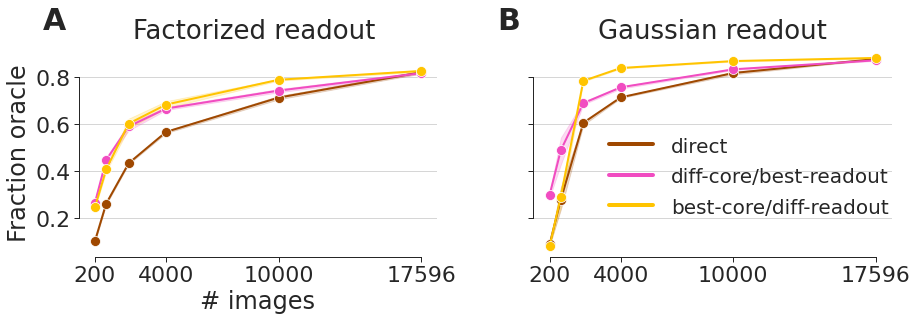

In [6]:
title = 'condition comparison'
scoring_measure = "fraction_oracle" 
sns.set_context("paper")        
col_order = ['Factorized readout ', 'Gaussian readout']
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,6,8) ]


paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.5), sns.axes_style('ticks'):        
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Condition", 
                    col="Readout",
                    col_order=col_order,
                    kind="line",
                    marker="o",
                    data=data,
                    palette=palette, 
                    height=5, 
                    aspect=.9)          
       
    g.axes[0,0].set_ylabel(scoring_measure.replace('_', ' '))
    g.axes[0,0].set_xlabel('# images')
    g.axes[0,1].set_xlabel('# images')
    g._legend.texts[0].set_text("")
    g._legend.set_bbox_to_anchor((.84, .39, .1, .1))
    
    for h in g._legend.legendHandles[1:]:
        h.set_linewidth(4)
        
    for label in g._legend.texts:
            label.set_size(20)
    
    for i, ax in enumerate(g.axes.flatten()): 
        ax.set_title(ax.get_title()[10:])   
        ax.yaxis.grid(True)
        ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.text(0.5, 1.05, ax.get_title(),
                horizontalalignment='center',
                fontsize=26,
                transform=ax.transAxes)
        ax.set_title("")
        
        ax.text(-0.1, 1.09, string.ascii_uppercase[i], transform=ax.transAxes, size=30, weight='bold') 
        
        if i > 0:
            ax.set(xlabel="")
        else:
            ax.set_xlabel("# images", fontsize=24)
            ax.set_ylabel("Fraction oracle", fontsize=24)
    
    sns.despine(trim=True)
    plt.tight_layout()
    #g.fig.savefig('figures/' + title + '.pdf', dpi=150, bbox_inches='tight')

In [16]:
data.loc[(data['Condition'] == "best-core/diff-readout") & (data['Readout'] == 'Factorized readout ') & (data['# images'] == 200)].score

3     0.094624
8     0.102092
12    0.092423
19    0.095972
24    0.100179
Name: score, dtype: float64

In [17]:
data.loc[(data['Condition'] == "best-core/diff-readout") & (data['Readout'] == 'Gaussian readout') & (data['# images'] == 200)].score

3     0.034973
8     0.034278
12    0.036289
19    0.026661
24    0.035859
Name: score, dtype: float64

# Animal transfer

In [ ]:
experiment_names = ["Real, Direct, se2d_fullgaussian2d, 20457-5-9", 
                    "Real, direct (RANDOM fixed core 128), se2d_fullgaussian2d, 20457-5-9",
                    "Real, direct (RANDOM fixed core 64), se2d_fullgaussian2d, 20457-5-9",
                    "Real, direkt (VGG16 fixed core), taskdriven_fullgaussian2d, VGG16 -> 20457-5-9",
                    "Real, Direct, taskdriven_fullgaussian2d (random VGG16 fixed core), 20457-5-9"]
new_names = ["direct", "random core 128", "random core 64", 'VGG16', 'random VGG16 ']

data = pd.DataFrame()
for experiment_name, new_name in zip(experiment_names, new_names):
    
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore * Experiments.Restrictions 
                         & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_['transfer_description'] = new_name
    data = pd.concat([data, data_])
    
# Filter out best performing models over model seeds
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data = data.sort_values('score', ascending=False).drop_duplicates(['transfer_description', 
                                                                   'neuron_n',
                                                                   'image_n', 
                                                                   'neuron_base_seed',
                                                                   'image_base_seed']).sort_values(['transfer_description', 'neuron_n', 'image_n'])


experiment_names = ["Real, core_transfer (animal), se2d_fullgaussian2d, 11-set -> 20457-5-9", 
                    "Real, core_transfer (animal), se2d_fullgaussian2d, 4-set -> 20457-5-9",
                    "Real, core_transfer (animal), se2d_fullgaussian2d, 20505-6-1 -> 20457-5-9",
                    "Real, core_transfer (animal) NO CORTEX, se2d_fullgaussian2d, 11-set -> 20457-5-9",
                    "Real, core_transfer (animal), se2d_fullgaussian2d, 4 DiffAnimalsDiffImages -> 20457-5-9"]

new_names = ['11-S', '4-S: matched', "1-S", "11-S: no cortex", '4-S: diff animals ']

for experiment_name, new_name in zip(experiment_names, new_names):
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_ = pd.concat([data_, data_['dataset_config'].apply(pd.Series)], axis = 1)
    data_['transfer_description'] = new_name
    data = pd.concat([data, data_])
    
data = data.rename(columns = {'neuron_n': '# neurons', 'image_n': "# images"})

In [ ]:
title = 'animal transfer'

palette = sns.color_palette('bright')[:2] + sns.color_palette('bright')[1:5]
palette += [(0., 0., 0.), (0.,0.,0.), (0.,0.,0.), (0., 0., 0.)]
scoring_measure = "fraction_oracle"
hues = ['direct', 
        '11-S', 
        '11-S: no cortex',
        '4-S: matched', 
        '4-S: diff animals ', 
        '1-S', 
        'VGG16', 
        'random VGG16 ',
        'random core 128',
        'random core 64'] 

paper_rc = {'lines.linewidth': 4, 'lines.markersize': 13} #, 'axes.linewidth': 2  
with sns.plotting_context('paper', rc=paper_rc, font_scale=4.), sns.axes_style('ticks'):      
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="transfer_description", 
                    kind="line",
                    hue_order=hues,
                    data=data,
                    marker="o",
                    height=14,
                    aspect=.84,
                    palette=palette,
                   ) 
    ax = g.axes[0, 0]
    g.axes[0,0].set_ylabel(scoring_measure.replace('_', ' '))
    
    
    h, l = ax.get_legend_handles_labels()
    g._legend.remove()
    leg = g.fig.legend(h, l, ncol=2, frameon=False, bbox_to_anchor=(0.45, 0.25, 0.5, 0.2), fontsize=32, columnspacing=.01)
    
    for i, style in zip([2, 6, 7, 8], [(0,(5,5)),':', '-.', (0,(5,5))]):
        g.axes[0,0].lines[i].set_linestyle(style)
        leg.legendHandles[i+1].set_linestyle(style)
    
    leg.texts[0].set_text("")
    g.axes[0,0].lines[2].set_zorder(100)
    
    for label in leg.texts:
        label.set_size(33)
        
    for h in leg.legendHandles[1:]:
        h.set_linewidth(4.5)
    
    ax = g.axes[0, 0]
    ax.set_ylim(-.1, 1)
    ax.set_xlim(-100, 4500)
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    ax.set_xticks(np.unique(data['# images'])[[0, 2, 3, 4, 5]])
    ax.set_xticks(np.unique(data['# images']), minor=True)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=50)
    ax.set_ylabel("Fraction oracle", fontsize=50)
    ax.tick_params(labelsize=42)
    
    sns.despine(trim=True)
    name = title.title().replace(" ", "").replace(",", "-")
    g.fig.tight_layout()
    #g.fig.savefig('figures/' + name + '.pdf', dpi=150,  bbox_inches='tight')

# Best core transfer - Comparison of feature sharing and Cortex data

In [ ]:
# full core data
data = pd.DataFrame()

conditions = ['share feat, cortex', '~share feat, cortex', 'share feat, ~cortex', '~share feat, ~cortex']
for experiment_name, condition in zip(["Real, core_transfer (best), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (best) SHARE_FEAUTURES=False, se2d_fullgaussian2d, 4-set -> 4-set",
                        "Real, core_transfer (best) NO CORTEX, se2d_fullgaussian2d, 4-set -> 4-set",
                        "Real, core_transfer (best) SHARE_FEAUTURES=False and NO CORTEX, se2d_fullgaussian2d, 4-set -> 4-set"], conditions):
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data_['condition'] = condition
    data = pd.concat([data, data_])
    
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data = data.loc[data['# neurons'] == 972]

In [ ]:
scoring_measure = "fraction_oracle"
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,6,7,8) ]

title = 'Transfer core: share_feature and cortex comparison'
    
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):     
    
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="condition", 
                    kind="line",
                    data=data,
                    markers=True,
                    height=7,
                    aspect=0.9,
                    palette=palette) 
    
    ax = g.axes[0, 0]
    
    ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=28)
    ax.set_ylabel(scoring_measure.replace('_', ' ').capitalize(), fontsize=28)
    ax.tick_params(labelsize=25)
    ax.set_yticks([.1, .3, .5, .7, .9])
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    sns.despine(trim=True)
    plt.tight_layout()
    g._legend.set_bbox_to_anchor((0.35, 0.35, 0.5, 0.2))
    plt.title(title)
    name = title.title().replace(" ", "").replace(",", "-")
    #g.fig.savefig('figures/' + name + '.pdf', dpi=150, bbox_inches='tight')

# Directly trained - Comparison of feature sharing and Cortex data

In [ ]:
experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set',
                    "Real, Direct, se2d_fullgaussian2d, [cortex, ~features], 4-set",
                    "Real, Direct, se2d_fullgaussian2d, [~cortex, features], 4-set",
                    "Real, Direct, se2d_fullgaussian2d, [~cortex, ~features], 4-set"]

names = ['cortex-data, feature-sharing', 
         'cortex-data, no feature-sharing', 
         'no cortex-data, feature-sharing', 
         'no cortex-data, no feature-sharing']
# Fetch data
data = pd.DataFrame()
for experiment_name, name in zip(experiment_names, names):
    data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_['condition'] = name
    data = pd.concat([data, data_])
    
# Filter out relevant data
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
data = data.loc[data['multi_match_n'] == 3625]

# Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['condition', 
                                                                   'multi_match_n',
                                                                   'image_n', 
                                                                   'multi_match_base_seed',
                                                                   'image_base_seed']).sort_values(['condition', 'multi_match_n', 'image_n'])
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
#data = data.loc[data['# neurons'].isin([50, 500, 3625])]


In [ ]:
scoring_measure = "fraction_oracle"
palette = [sns.color_palette('bright')[i] for i in (8,9,7,6) ]

title = 'Direct training - cortex and feature comparison'
    
paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):     
    
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="condition", 
                    kind="line",
                    data=data,
                    marker='o',
                    height=7,
                    aspect=0.9,
                    palette=palette) 
    
    ax = g.axes[0, 0]
    
    ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=28)
    ax.set_ylabel(scoring_measure.replace('_', ' ').capitalize(), fontsize=28)
    ax.tick_params(labelsize=25)
    ax.set_yticks([.1, .3, .5, .7, .9])
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    sns.despine(trim=True)
    plt.tight_layout()
    
    g._legend.texts[0].set_text("")
    g._legend.set_bbox_to_anchor((.74, .39, .1, .1))
    
    #g.fig.savefig('figures/' + title.title().replace(" ", "").replace(",", "-") + '.pdf', dpi=150, bbox_inches='tight')

# Figure for dataset explanation

In [ ]:
import matplotlib as mpl
datasets = np.zeros((10, 8))
datasets[0, :4] = 1
datasets[-2, 0] = 2
datasets[-1, 0] = 3
datasets[np.arange(1, 8), [3, 3, 4, 5, 6, 7, 7]] = 4

palette = sns.color_palette('bright')[:2] + sns.color_palette('bright')[1:5]
colors = ['None', palette[3], palette[0], palette[-1], palette[1]]

bounds = [0, 1, 2, 3, 4]
cmap = mpl.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(5, 5), dpi=250)
ax.imshow(datasets, cmap=cmap) #, aspect=1.05);
ax.set(xticks=np.arange(datasets.shape[1]) + .5, yticks=np.arange(datasets.shape[0]) + .5, xticklabels=[], yticklabels=[])
ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none')
ax.grid(c='k')
# text
image_text = ax.text(3.5, -1, "Image sets", fontsize=20, ha='center')
neuron_text = ax.set_ylabel("Neuron sets", fontsize=20);

# legend
from matplotlib.lines import Line2D
labels = ["4-S: matched", "Evaluation", "1-S", "11-S", "4-S: diff animals"]
cs = colors[1:] + [palette[-2]]
order = [1, 3, 0, 4, 2]
legend_elements = [Line2D([], [], marker="s", markersize=13, linewidth=0, color=cs[o], label=labels[o]) for o in order]
lgd = ax.legend(handles=legend_elements, loc=(1.03, .52), edgecolor="None", fontsize=18, handletextpad=0.01);

# make the shaded part 
yloc = 0
for xloc in [0, 1, 2]:
    xlocs = np.arange(xloc, xloc+.48, .02)
    for ind, xloc in enumerate(xlocs):
        alpha=1#ind/len(xlocs)
        ax.plot([xloc, xloc], [yloc-.5, yloc+.47], lw=1., c=colors[-1], alpha=alpha)

xlocs = np.arange(2.847, 3.16, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.5, yloc+.47], lw=1., c=colors[-1], alpha=alpha)       

xlocs = np.arange(3.17, 3.48, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.5, yloc+.47], lw=1., c=palette[-2], alpha=alpha)

xloc, yloc = 4, 3
xlocs = np.arange(xloc, xloc+.47, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.46, yloc+.46], lw=1., c=palette[-2], alpha=alpha)

xloc, yloc = 5, 4
xlocs = np.arange(xloc, xloc+.461, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.46, yloc+.46], lw=1., c=palette[-2], alpha=alpha)  

xloc, yloc = 7, 6
xlocs = np.arange(xloc, xloc+.465, .02)
for ind, xloc in enumerate(xlocs):
    alpha = 1
    ax.plot([xloc, xloc], [yloc-.46, yloc+.46], lw=1., c=palette[-2], alpha=alpha)   
# add the lines
ax_animal = fig.add_axes([.825, .125, .02, .755])
ax_animal.set_ylim(0, datasets.shape[0] * .1)
import matplotlib.patches as patches
animal_id0 = patches.Rectangle((0, 0.11), 1., .08, linewidth=1, facecolor='k')
animal_id1 = patches.Rectangle((0, 0.01), 1., .08, linewidth=1, facecolor='k')
animal_id2 = patches.Rectangle((0, 0.91), 1., .08, linewidth=1, facecolor='k')
animal_id3 = patches.Rectangle((0, .61), 1., .28, linewidth=1, facecolor='k')
animal_id4 = patches.Rectangle((0, .41), 1., .18, linewidth=1, facecolor='k')
animal_id5 = patches.Rectangle((0, .31), 1., .08, linewidth=1, facecolor='k')
animal_id6 = patches.Rectangle((0, .21), 1., .08, linewidth=1, facecolor='k')

# Add the patch to the Axes
ax_animal.add_patch(animal_id0)
ax_animal.add_patch(animal_id1)
ax_animal.add_patch(animal_id2)
ax_animal.add_patch(animal_id3)
ax_animal.add_patch(animal_id4)
ax_animal.add_patch(animal_id5)
ax_animal.add_patch(animal_id6)

ax_animal.axis('off')
ax.text(8.04, 9.2, "Unique animals", fontsize=17, rotation=-90) #, va='center', ha='center')
#fig.savefig('figures/' + 'datasets.pdf', bbox_inches='tight')

# Readout positions: Factorized vs Gaussian

In [ ]:
# This takes long! -> Simplify!

# Get data
data = pd.DataFrame()
for experiment_name in ["Real, core_transfer (best), se2d_fullgaussian2d, 4-set -> 4-set", 
                        "Real, core_transfer (best from GAUSSIAN!), se2d_spatialxfeaturelinear, 4-set -> 4-set"]:
    
    data_ = pd.DataFrame((TrainedModelTransfer * Dataset * Model * Trainer * Seed * Transfer.proj() * OracleScoreTransfer * ExperimentsTransfer.Restrictions 
                          & 'experiment_name="{}"'.format(experiment_name)).fetch())
    transfer_hashes = list(data_.transfer_hash)
    transfer_ = get_transfer(transfer_hashes)
    data_ = pd.merge(data_, transfer_, how='inner', on=['transfer_hash', 'transfer_fn'])
    data = pd.concat([data, data_])
data['readout'] = [row.model_fn.split('.')[-1][5:] for loc, row in data.iterrows()]
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})

# Get weights weights from factorized readout
model_fn = "nnsysident.models.models.se2d_spatialxfeaturelinear"
all_weights = []
for n_images in np.unique(data['# images']):
    my_data = data.loc[(data['# images'] == n_images) & (data['multi_match_base_seed'] == 1) & (data['model_fn'] == model_fn)]
    key = dict(model_hash=my_data.model_hash.values[0],
               dataset_hash=my_data.dataset_hash.values[0], 
               trainer_hash = my_data.trainer_hash.values[0],
              transfer_hash = my_data.transfer_hash.values[0])
    key = (TrainedModelTransfer & key).proj().fetch1()
    dataloaders, model = TrainedModelTransfer().load_model(key=key) 
    weights = model.readout['22564-3-12-0'].normalized_spatial
    all_weights.append(weights)

# Get sigmas and mus from gaussian readout
model_fn = "nnsysident.models.models.se2d_fullgaussian2d"
mus = []
sigmas = []
for n_images in np.unique(data['# images']):
    my_data = data.loc[(data['# images'] == n_images) & (data['multi_match_base_seed'] == 1) & (data['model_fn'] == model_fn)]
    key = dict(model_hash=my_data.model_hash.values[0],
               dataset_hash=my_data.dataset_hash.values[0], 
               trainer_hash = my_data.trainer_hash.values[0],
              transfer_hash = my_data.transfer_hash.values[0])
    key = (TrainedModelTransfer & key).proj().fetch1()
    dataloaders, model = TrainedModelTransfer().load_model(key=key) 
    mus.append(model.readout['22564-3-12-0'].mu[0].detach().numpy())
    sigmas.append(model.readout['22564-3-12-0'].sigma[0].detach().numpy())

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

# Use these neuron indices
final_indices_raw = np.array([3511, 3105, 3036, 3751])
final_indices = final_indices_raw - (985 + 979 + 978)


def transform_spatial_scale(x_init, init_range, final_range):
    return (x_init - min(init_range)) * (max(final_range - min(final_range)) / max(init_range - min(init_range))) + min(final_range)

def new_cmap(cmap):
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    my_cmap = ListedColormap(my_cmap)
    return my_cmap

init_range_w = [-1, 1]
final_range_w = [0, 22]

init_range_h = [-1, 1]
final_range_h = [0, 50]

cmap_contourf = new_cmap(plt.get_cmap("Reds"))
cmap_imshow = new_cmap(plt.get_cmap("Blues"))

fig, axes = plt.subplots(len(final_indices), 3, figsize=(7, 5), dpi=150)

image_ns = [200, 2000, 17596]
i = 0

for final_idx in final_indices:
    
    for image_set_ind in np.where(np.isin(np.unique(data['# images']), np.array(image_ns)))[0]:
            
        ax = axes.flat[i]
        i += 1

        weights = all_weights[image_set_ind][final_idx].detach().numpy()
        A = sigmas[image_set_ind][final_idx]
        mean = mus[image_set_ind][final_idx].squeeze()
        gaussian_perf = corrs1[image_set_ind][final_indices_raw[np.where(final_indices == final_idx)[0]]][0]
        featurex_perf = corrs2[image_set_ind][final_indices_raw[np.where(final_indices == final_idx)[0]]][0]
        
        mean = np.array([mean[1], mean[0]])
        #A = np.array([[A[1,1], A[1,0]], [A[0,1], A[0,0]]])
        A = A[:,::-1]
        covariance_mat = np.dot(A, A.T)

        scale_h = np.abs(np.diff(final_range_h)[0]) / np.abs(np.diff(init_range_h)[0])
        scale_w = np.abs(np.diff(final_range_w)[0]) / np.abs(np.diff(init_range_w)[0])

        # define the range for x(height) and y(width)
        x, y = np.mgrid[-1:1:.04, -1:1:.09090909090909091]
        pos = np.dstack((x, y))

        x_new, y_new = np.mgrid[.5:50.5:1, .5:22.5:1]
        rv = multivariate_normal(mean, covariance_mat)

        # plot them  
        ax.contourf(x_new, y_new, rv.pdf(pos), cmap=cmap_contourf)
        #ax.plot(mean[0],mean[1], marker="x", markersize=7, color="red")
        ax.imshow(weights, cmap=cmap_imshow)
        
        if i < 4:
            ax.set_title('# images/scan: ' + str(int(np.unique(data['# images'])[image_set_ind]/4)), fontsize=13)
        
        ax.set(xticklabels=[], yticklabels=[])
        ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none')
    
        ax.barh([2, 4.7], [featurex_perf * 15, gaussian_perf * 15], height=1.2, left=1.5, color=['k', 'r'])
        ax.plot([1.5, 1.5], [1, 5.7], lw=1, c='k')
        ax.text(featurex_perf * 15 + 3, 2.2, '{:.2f}'.format(featurex_perf), va='center', fontsize=8.5, color='k')
        ax.text(gaussian_perf * 15 + 3, 5, '{:.2f}'.format(gaussian_perf), va='center', fontsize=8.5, color='r')
        ax.grid(True, linestyle=":")
           
fig.tight_layout()
fig.subplots_adjust(wspace=.1, hspace=.01)
#fig.savefig('figures/' + 'readoutpositions - 4 neurons.pdf', dpi=150)